In [1]:
## Import libraries
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn
from torch.utils.data import TensorDataset

source = "../source"
sys.path.append(source)

from preprocessing import Encoding
from compilation import Compiler, ScalarTracker, ActivationTracker
import publication
import simulate
import models

device = torch.device("cpu")

save = False

In [2]:
## Load settings
settings = "default"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/2 points.txt", sep=" ", header=0)
    .loc[settings]
    .to_numpy()
)
model_type = getattr(models, model_type)

if nonlinearity == "none":
    nonlinearity = None
else:
    nonlinearity = getattr(torch.nn.functional, nonlinearity)

In [3]:
lr = lr / 2
n_epochs = n_epochs * 2

In [4]:
## Generate data
input_dim, output_dim = in_dim, out_dim

inputs = np.array([[-1] * input_dim, [-1 + np.sqrt(dx2)] * input_dim]) / np.sqrt(
    input_dim
)
outputs = np.array([[0.6] * output_dim, [0.6 + np.sqrt(dy2)] * output_dim]) / np.sqrt(
    output_dim
)
names = ["A", "B"]
data = TensorDataset(
    torch.from_numpy(inputs.astype(np.float32)).to(device),
    torch.from_numpy(outputs.astype(np.float32)).to(device),
)

encoding = Encoding(dict(zip(names, inputs)))

train_datasets = [data]

tracked_datasets = train_datasets

In [5]:
## Instantiate model
model = model_type(
    input_size=input_dim,
    output_size=output_dim,
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
    non_linearity=nonlinearity,
    encoding=encoding,
)

In [6]:
## Setup compiler
criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][hidden_layer], datasets=tracked_datasets
    ),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], datasets=tracked_datasets
    ),
}

In [7]:
## Training run
compiler.training_run(
    train_datasets,
    n_epochs=n_epochs,
    batch_size=100,
)

Training:  17%|█▋        | 1044/6000 [00:20<01:38, 50.30steps/s, train_loss=0.05125, val_loss=0.05125]


KeyboardInterrupt: 

In [8]:
## Get data
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()

loss = compiler.trackers["loss"].get_trace().copy()
train_loss = loss.groupby("Epoch").mean()
train_loss = train_loss.to_numpy().ravel()

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()

h_A = [np.array(data.loc[epoch, 0, "A"]) for epoch, data in data_hid.groupby("Epoch")]
h_B = [np.array(data.loc[epoch, 0, "B"]) for epoch, data in data_hid.groupby("Epoch")]
y_A = [
    np.array(data.loc[epoch, 0, "A"]) for epoch, data in data_output.groupby("Epoch")
]
y_B = [
    np.array(data.loc[epoch, 0, "B"]) for epoch, data in data_output.groupby("Epoch")
]

y_true_A, y_true_B = outputs[0], outputs[1]
dy2 = np.sum((y_true_B - y_true_A) ** 2)
h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
w = np.array(
    [
        y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
        for epoch in epochs
    ]
)
y0_mean = np.sum((0.5 * ((y_A[0] + y_B[0]) - (y_true_B + y_true_A))) ** 2)

h0, y0, w0, dy = h2[0], y2[0], w[0], dy2

In [9]:
## Fit effective learning rates
eta_h_opt, eta_y_opt, loss = simulate.optimize_eta(
    h2, y2, w, dx2, dy2, guesses=np.logspace(-6, 2, 100)
)

sol = scipy.integrate.solve_ivp(
    simulate.der,
    [0, len(epochs)],
    [h0, y0, w0],
    args=(eta_h_opt, eta_y_opt, dx2, dy2),
    dense_output=True,
)
t = np.linspace(0, len(epochs), len(epochs))
z = sol.sol(t)

eta_y_mean_opt = simulate.optimize_eta_y_mean(z, train_loss, dy2, y0_mean)

loss_theory = simulate.loss(t, z, eta_y_mean_opt, dy2, y0_mean)

Loss: 0.0004577149257211824
Loss: 0.00742165931642785


/home/loek/projects/universality/experiments/../source/simulate.py:104: RuntimeWarning: overflow encountered in square
  model_loss = np.sum((pred - train_loss) ** 2)
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/loek/projects/universality/experiments/../source/simulate.py:104: RuntimeWarning: overflow encountered in square
  model_loss = np.sum((pred - train_loss) ** 2)
/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


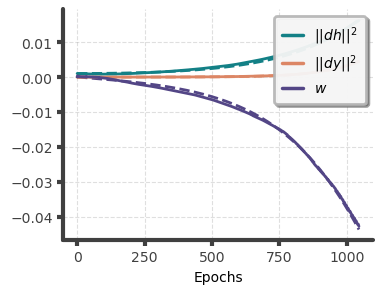

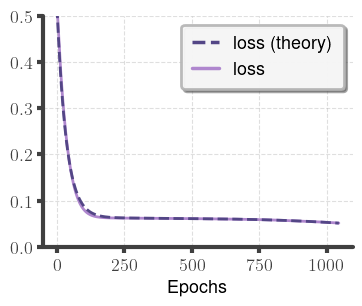

In [10]:
traj_path = "plots/2_points/trajectories/"

publication.set_color_mixed()
figsize = (4, 3)

# Plot 3-d dynamical system
fig, ax = plt.subplots(figsize=figsize)
plt.plot(t, z[0], linestyle="--")
plt.plot(t, z[1], linestyle="--")
plt.plot(t, z[2], linestyle="--")
plt.gca().set_prop_cycle(None)
ax.plot(t, h2, label="$||dh||^2$")
ax.plot(t, y2, label="$||dy||^2$")
ax.plot(t, w, label="$w$")
ax.legend()
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=traj_path + "ode/" + settings + ".png")
else:
    publication.plt_show()

# Plot loss
fig, ax = plt.subplots(figsize=figsize)
plt.gca().set_prop_cycle(None)
ax.plot(0, 0)
ax.plot(0, 0)
ax.plot(t, loss_theory, label=r"loss (theory)", linestyle="--")
ax.plot(0, 0)
ax.plot(t, train_loss, label="loss", zorder=1)
ax.legend()
plt.ylim(0, 0.5)
plt.xlabel("Epochs")
if save:
    publication.plt_show(save_path=traj_path + "loss/" + settings + ".png")
else:
    publication.plt_show()